# Differential Privacy (DP) in the context of image classification

In [32]:
import tensorflow as tf
import keras
import keras_vggface
from keras_vggface.vggface import VGGFace
# Had to change code in keras vggface to make it work changed model.py line 20 as shown here https://stackoverflow.com/a/71379206
import numpy as np
import matplotlib as mpl
import keras_vggface.utils
import PIL
import os
import os.path
import matplotlib.pyplot as plt
from keras.layers import Dense, Flatten, Input
from keras_vggface.vggface import VGGFace
from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPGradientDescentGaussianOptimizer
import tensorflow_privacy

train_seed = 30
split = 0.2

train_dataset = keras.utils.image_dataset_from_directory('./AIGroupFaces', shuffle=True, image_size=(224, 224), batch_size=64, seed=train_seed, validation_split=split, subset='training')
val_dataset = keras.utils.image_dataset_from_directory('./AIGroupFaces', shuffle=True, image_size=(224, 224), batch_size=64, seed=train_seed, validation_split=split, subset='validation')

def create_cnn_model(num_classes):
    model = tf.keras.models.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(num_classes,activation='softmax')
])
    return model

def basic_compile(model, LR=0.0001):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
    return model

def train_model(model):
    history = model.fit(train_dataset, epochs=20, validation_data=val_dataset)
    return history

data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.2), ])

def create_tl_model(num_classes):
    resnet_base = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3))
    resnet_base.trainable = False
    last_layer = resnet_base.get_layer('avg_pool').output

    inputs = tf.keras.Input(shape=(224, 224, 3))

    x = data_augmentation(inputs)
    x = resnet_base(x)
    x = Flatten(name='flatten')(x)

    out = Dense(num_classes, name='classifier')(x)

    custom_resnet_model = keras.Model(inputs, out)
    return model


#Privacy
privacy_loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction=tf.losses.Reduction.NONE)

def create_DP_optimiser(l2_norm_clip=1.1, noise_multiplier=5, num_microbatches=16, learning_rate=0.0001):
    optimiser = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate
)
    return optimiser

def compile_dp_model(model):
    optimiser = create_DP_optimiser()
    model.compile(optimizer=optimiser,
        loss = privacy_loss,
        metrics=['accuracy'])
    
    return model

dp_train_dataset = keras.utils.image_dataset_from_directory('./Faces', shuffle=True, image_size=(224, 224), batch_size=16, seed=train_seed, validation_split=split, subset='training')
dp_val_dataset = keras.utils.image_dataset_from_directory('./Faces', shuffle=True, image_size=(224, 224), batch_size=16, seed=train_seed, validation_split=split, subset='validation')

tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=0,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

def train_dp_model(model):
    history = model.fit(dp_train_dataset, epochs=20, validation_data=dp_val_dataset, callbacks=[callback])
    return history

Found 310 files belonging to 4 classes.
Using 248 files for training.
Found 310 files belonging to 4 classes.
Using 62 files for validation.
Found 300 files belonging to 4 classes.
Using 240 files for training.
Found 300 files belonging to 4 classes.
Using 60 files for validation.


## Create and train a basic CNN to recognise a face

In [2]:
model = create_cnn_model(4)
model = basic_compile(model)
history = train_model(model)


Epoch 1/20


/Users/jacobmoran/miniforge3/envs/AI310/lib/python3.10/site-packages/keras/backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-05-10 19:45:51.242846: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-10 19:45:51.243056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 2.5250 - accuracy: 0.4919

2023-05-10 19:45:52.832861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 2s 493ms/step - loss: 2.5250 - accuracy: 0.4919 - val_loss: 0.6519 - val_accuracy: 0.6935
Epoch 2/20
4/4 [==============================] - 2s 452ms/step - loss: 0.9590 - accuracy: 0.6129 - val_loss: 0.6329 - val_accuracy: 0.7581
Epoch 3/20
4/4 [==============================] - 2s 451ms/step - loss: 0.7056 - accuracy: 0.7540 - val_loss: 0.5547 - val_accuracy: 0.7419
Epoch 4/20
4/4 [==============================] - 2s 449ms/step - loss: 0.3742 - accuracy: 0.9194 - val_loss: 0.5016 - val_accuracy: 0.9032
Epoch 5/20
4/4 [==============================] - 2s 448ms/step - loss: 0.3438 - accuracy: 0.9113 - val_loss: 0.4083 - val_accuracy: 0.8387
Epoch 6/20
4/4 [==============================] - 2s 448ms/step - loss: 0.2781 - accuracy: 0.9194 - val_loss: 0.4108 - val_accuracy: 0.8226
Epoch 7/20
4/4 [==============================] - 2s 446ms/step - loss: 0.2141 - accuracy: 0.9556 - val_loss: 0.3127 - val_accuracy: 0.9194
Epoch 8/20
4/4 [===============

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')

plt.title("Basic CNN model - Accuracy vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

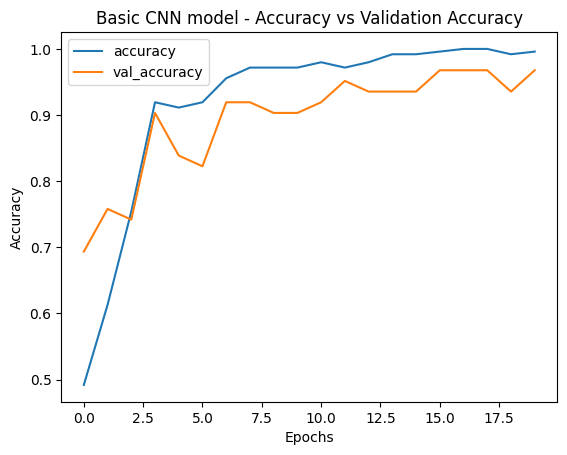

In [9]:
plt.show()

In [4]:
from sklearn.metrics import confusion_matrix
import itertools

y_pred = []
y_true = []
for images, labels in val_dataset.unbatch().batch(1).as_numpy_iterator():
    y_true.append(labels[0])
    y_pred.append(np.argmax(model.predict(images), axis=-1)[0])

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Get the class names
class_names = train_dataset.class_names

1/1 [==============================] - 0s 10ms/step


2023-05-10 19:46:26.544082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 11ms/step


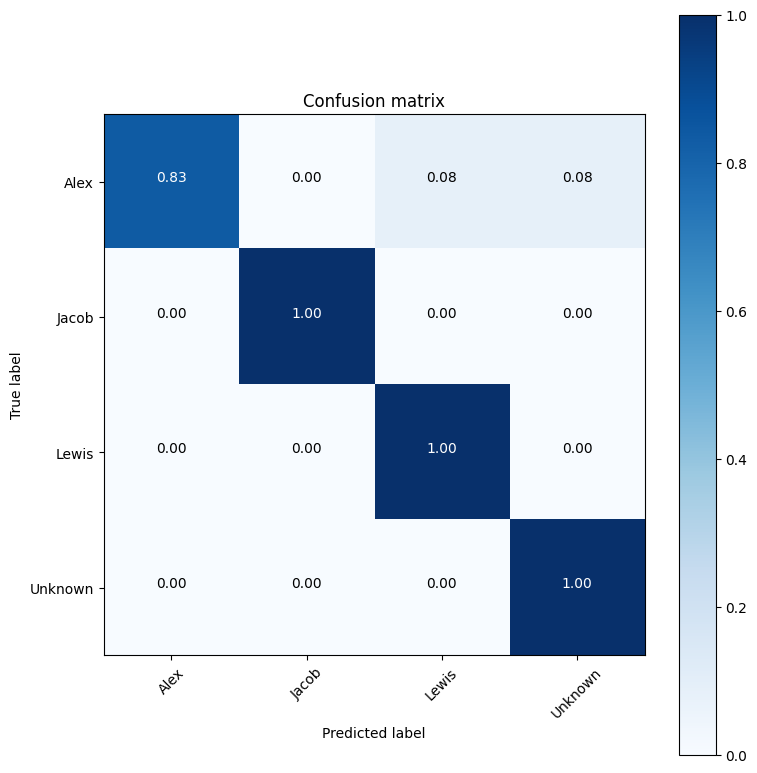

In [5]:
# Plot the confusion matrix
plot_confusion_matrix(cm, class_names)

## Create and train basic transfer learned model
This will allow us to compare the base accuracys of both models and then compare to the DP versions

In [6]:
basic_tl_model = create_tl_model(4)
basic_tl_model = basic_compile(basic_tl_model)
basic_tl_model_history = train_model(basic_tl_model)

Epoch 1/20


/Users/jacobmoran/miniforge3/envs/AI310/lib/python3.10/site-packages/keras/backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-05-10 19:46:30.433720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 0.3326 - accuracy: 0.8548

2023-05-10 19:46:31.951844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 2s 477ms/step - loss: 0.3326 - accuracy: 0.8548 - val_loss: 0.1841 - val_accuracy: 0.9194
Epoch 2/20
4/4 [==============================] - 2s 451ms/step - loss: 0.0858 - accuracy: 0.9637 - val_loss: 0.2635 - val_accuracy: 0.9355
Epoch 3/20
4/4 [==============================] - 2s 452ms/step - loss: 0.1912 - accuracy: 0.9355 - val_loss: 0.1266 - val_accuracy: 0.9355
Epoch 4/20
4/4 [==============================] - 2s 449ms/step - loss: 0.0368 - accuracy: 0.9960 - val_loss: 0.1830 - val_accuracy: 0.9194
Epoch 5/20
4/4 [==============================] - 2s 448ms/step - loss: 0.0968 - accuracy: 0.9718 - val_loss: 0.1418 - val_accuracy: 0.9516
Epoch 6/20
4/4 [==============================] - 2s 450ms/step - loss: 0.0423 - accuracy: 0.9960 - val_loss: 0.0556 - val_accuracy: 0.9839
Epoch 7/20
4/4 [==============================] - 2s 453ms/step - loss: 0.0265 - accuracy: 1.0000 - val_loss: 0.0929 - val_accuracy: 0.9677
Epoch 8/20
4/4 [===============

In [ ]:
plt.plot(basic_tl_model_history.history['accuracy'], label='accuracy')
plt.plot(basic_tl_model_history.history['val_accuracy'], label='val_accuracy')

plt.title("Basic TL model - Accuracy vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

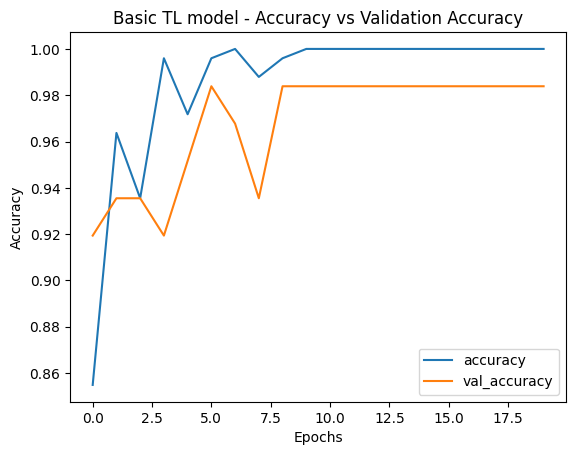

In [10]:
plt.show()

In [7]:
from sklearn.metrics import confusion_matrix
import itertools

y_pred = []
y_true = []
for images, labels in val_dataset.unbatch().batch(1).as_numpy_iterator():
    y_true.append(labels[0])
    y_pred.append(np.argmax(basic_tl_model.predict(images), axis=-1)[0])

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Get the class names
class_names = train_dataset.class_names

1/1 [==============================] - 0s 10ms/step


2023-05-10 19:47:05.416689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 11ms/step


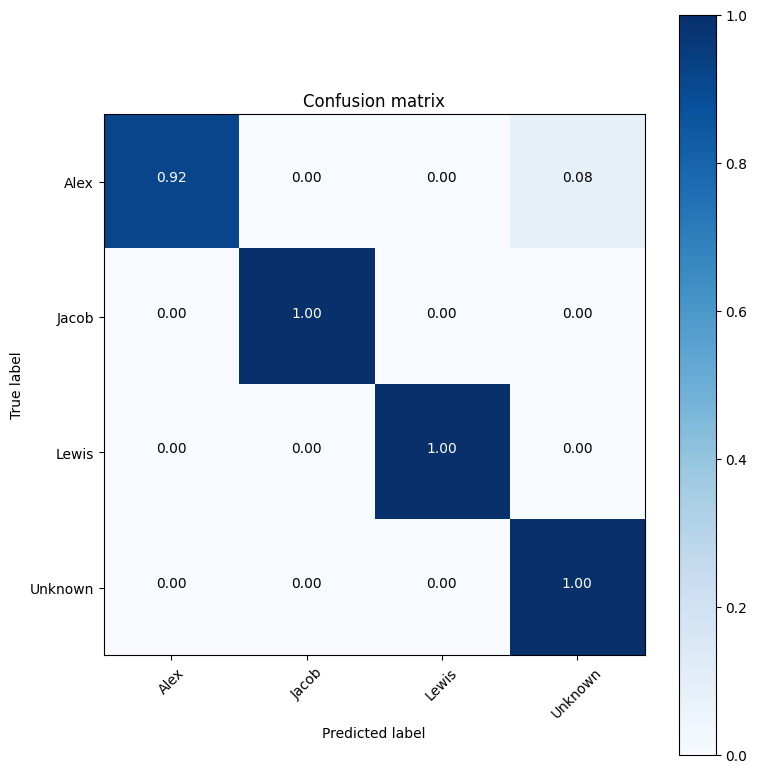

In [8]:
# Plot the confusion matrix
plot_confusion_matrix(cm, class_names)

## As we now have our base models to compare from we can now add the DP optimisers

In [21]:
cnn_DP_model = create_cnn_model(4)
cnn_DP_model = compile_dp_model(cnn_DP_model)
cnn_DP_history = train_dp_model(cnn_DP_model)

Epoch 1/20


2023-05-10 20:36:42.761516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - ETA: 0s - loss: 1.4651 - accuracy: 0.0750

2023-05-10 20:37:28.532410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 47s 3s/step - loss: 1.4651 - accuracy: 0.0750 - val_loss: 1.4493 - val_accuracy: 0.1167
Epoch 2/20
15/15 [==============================] - 46s 3s/step - loss: 1.4791 - accuracy: 0.0667 - val_loss: 1.4543 - val_accuracy: 0.1167
Epoch 3/20
15/15 [==============================] - 47s 3s/step - loss: 1.4910 - accuracy: 0.0750 - val_loss: 1.4619 - val_accuracy: 0.1667
Epoch 4/20
15/15 [==============================] - 47s 3s/step - loss: 1.5010 - accuracy: 0.1292 - val_loss: 1.4715 - val_accuracy: 0.2500
Epoch 5/20
15/15 [==============================] - 47s 3s/step - loss: 1.5160 - accuracy: 0.2083 - val_loss: 1.4894 - val_accuracy: 0.3000
Epoch 6/20
15/15 [==============================] - 47s 3s/step - loss: 1.5298 - accuracy: 0.3083 - val_loss: 1.4971 - val_accuracy: 0.3833
Epoch 7/20
15/15 [==============================] - 47s 3s/step - loss: 1.5448 - accuracy: 0.3167 - val_loss: 1.5025 - val_accuracy: 0.4167
Epoch 8/20
15/15 [=============

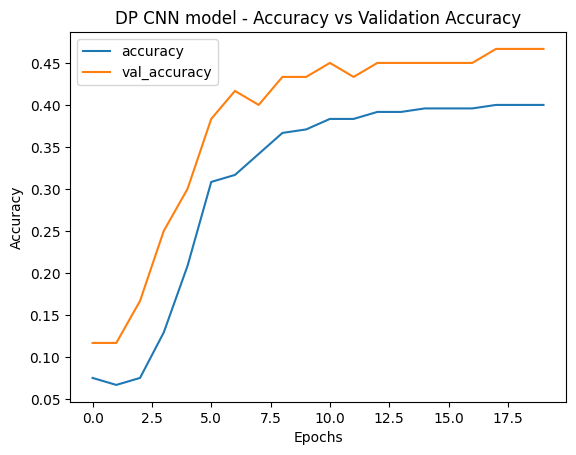

In [47]:
plt.plot(cnn_DP_history.history['accuracy'], label='accuracy')
plt.plot(cnn_DP_history.history['val_accuracy'], label='val_accuracy')

plt.title("DP CNN model - Accuracy vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [33]:
dp_tl_model = create_tl_model(4)
dp_tl_model = compile_dp_model(dp_tl_model)
dp_tl_model_history = train_dp_model(dp_tl_model)

Epoch 1/20


2023-05-10 21:03:07.596670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - ETA: 0s - loss: 2.1482 - accuracy: 0.4375

2023-05-10 21:03:54.873610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 49s 3s/step - loss: 2.1482 - accuracy: 0.4375 - val_loss: 2.2118 - val_accuracy: 0.4000
Epoch 2/20
15/15 [==============================] - 47s 3s/step - loss: 2.1673 - accuracy: 0.4375 - val_loss: 2.2320 - val_accuracy: 0.4000
Epoch 3/20
15/15 [==============================] - 47s 3s/step - loss: 2.1819 - accuracy: 0.4375 - val_loss: 2.2709 - val_accuracy: 0.4000
Epoch 4/20
15/15 [==============================] - 47s 3s/step - loss: 2.2016 - accuracy: 0.4375 - val_loss: 2.2556 - val_accuracy: 0.4000
Epoch 5/20
15/15 [==============================] - 48s 3s/step - loss: 2.2160 - accuracy: 0.4375 - val_loss: 2.2877 - val_accuracy: 0.4000
Epoch 6/20
15/15 [==============================] - 48s 3s/step - loss: 2.2366 - accuracy: 0.4375 - val_loss: 2.3022 - val_accuracy: 0.4000


In [37]:
import pickle
dp_tl_model_history = pickle.load(open('history.pkl', 'rb'))

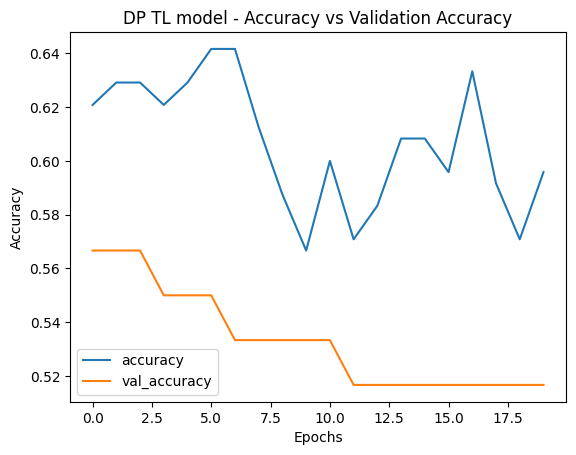

In [48]:
plt.plot(dp_tl_model_history['accuracy'], label='accuracy')
plt.plot(dp_tl_model_history['val_accuracy'], label='val_accuracy')

plt.title("DP TL model - Accuracy vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Overview

## Training times

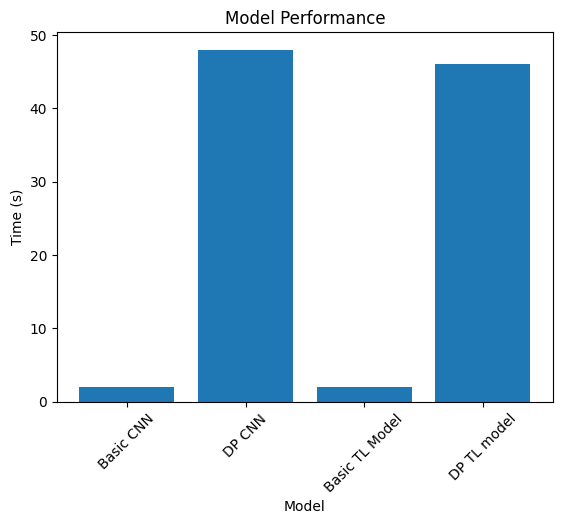

In [41]:

models = ['Basic CNN', 'DP CNN','Basic TL Model', 'DP TL model']
times = [2, 48, 2, 46]

fig, ax = plt.subplots()
ax.bar(models, times)

ax.set_xlabel('Model')
ax.set_ylabel('Time (s)')
ax.set_title('Model Performance')

plt.xticks(rotation=45)

plt.show()

## Accuracy

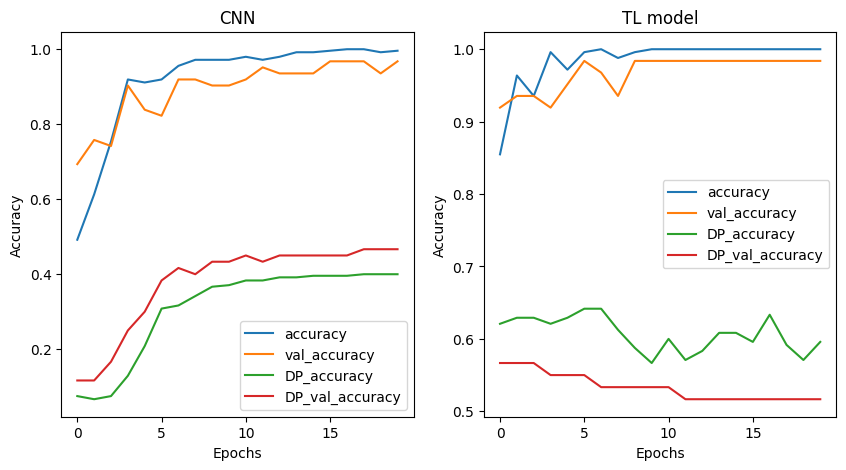

In [56]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

axs[0].plot(history.history['accuracy'], label='accuracy')
axs[0].plot(history.history['val_accuracy'], label='val_accuracy')
axs[0].plot(cnn_DP_history.history['accuracy'], label='DP_accuracy')
axs[0].plot(cnn_DP_history.history['val_accuracy'], label='DP_val_accuracy')

axs[1].plot(basic_tl_model_history.history['accuracy'], label='accuracy')
axs[1].plot(basic_tl_model_history.history['val_accuracy'], label='val_accuracy')
axs[1].plot(dp_tl_model_history['accuracy'], label='DP_accuracy')
axs[1].plot(dp_tl_model_history['val_accuracy'], label='DP_val_accuracy')

axs[0].set_title("CNN")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Accuracy")
axs[1].set_title("TL model")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")

axs[0].legend()
axs[1].legend()
plt.show()